# Linear Predictive Coding (LPC) Model for Speech Recognition

## Aim
To implement the Linear Predictive Coding (LPC) model for analyzing and reconstructing a speech signal, estimate the LPC coefficients, determine the formant frequencies, and compare them with standard vowel formant values to assess speech recognizability under low-bandwidth conditions.

## Problem Statement
Implement LPC analysis for a mobile communication app to analyze speech signals for efficient transmission and accurate recognition in low-bandwidth environments.

## 1. Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from scipy.io import wavfile
from scipy.linalg import solve_toeplitz
import librosa
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Set up plotting parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## 2. Define LPC Analysis Functions

In [2]:
class LPCAnalyzer:
    def __init__(self):
        """Initialize LPC Analyzer with standard vowel formant frequencies"""
        # Standard vowel formant frequencies (Hz) - reference values
        self.vowel_formants = {
            '/a/': {'F1': 730, 'F2': 1090, 'F3': 2440},
            '/e/': {'F1': 530, 'F2': 1840, 'F3': 2480},
            '/i/': {'F1': 270, 'F2': 2290, 'F3': 3010},
            '/o/': {'F1': 570, 'F2': 840, 'F3': 2410},
            '/u/': {'F1': 300, 'F2': 870, 'F3': 2240}
        }

    def load_audio(self, file_path):
        """Load audio file and return signal and sample rate"""
        try:
            # Try loading with librosa first (supports more formats)
            signal, sr = librosa.load(file_path, sr=None)
            print(f"Audio loaded successfully: {len(signal)} samples at {sr} Hz")
            return signal, sr
        except:
            # Fallback to scipy for WAV files
            sr, signal = wavfile.read(file_path)
            if len(signal.shape) > 1:  # Convert stereo to mono
                signal = np.mean(signal, axis=1)
            signal = signal.astype(np.float32) / np.max(np.abs(signal))
            print(f"Audio loaded successfully: {len(signal)} samples at {sr} Hz")
            return signal, sr

## 3. Task 1: Speech Signal Acquisition

Enter the path to your audio file: /content/newaudio.wav
Audio loaded successfully: 176128 samples at 44100 Hz


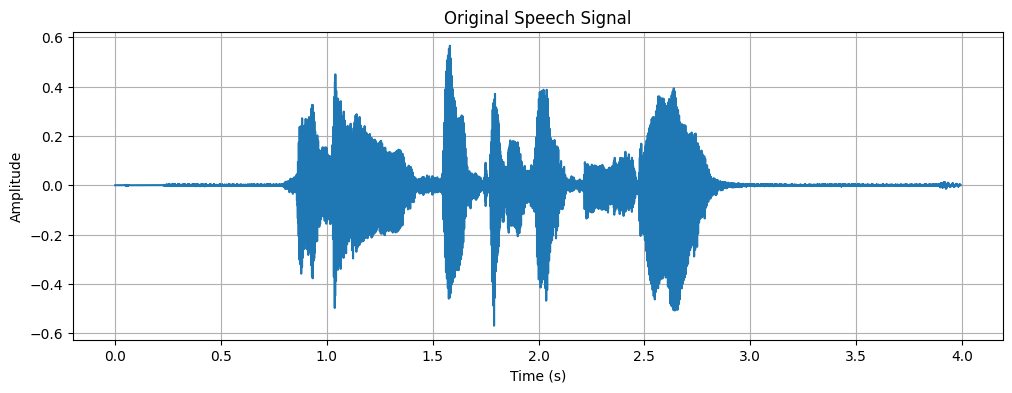

Signal duration: 3.99 seconds
Sample rate: 44100 Hz


In [3]:
# Initialize the analyzer
analyzer = LPCAnalyzer()

# Load your speech recording
# Replace 'your_audio_file.wav' with the path to your audio file
audio_file_path = input("Enter the path to your audio file: ")

# Load the audio
signal, sample_rate = analyzer.load_audio(audio_file_path)

# Plot the original signal
time = np.linspace(0, len(signal)/sample_rate, len(signal))
plt.figure(figsize=(12, 4))
plt.plot(time, signal)
plt.title('Original Speech Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

print(f"Signal duration: {len(signal)/sample_rate:.2f} seconds")
print(f"Sample rate: {sample_rate} Hz")

## 4. Signal Preprocessing

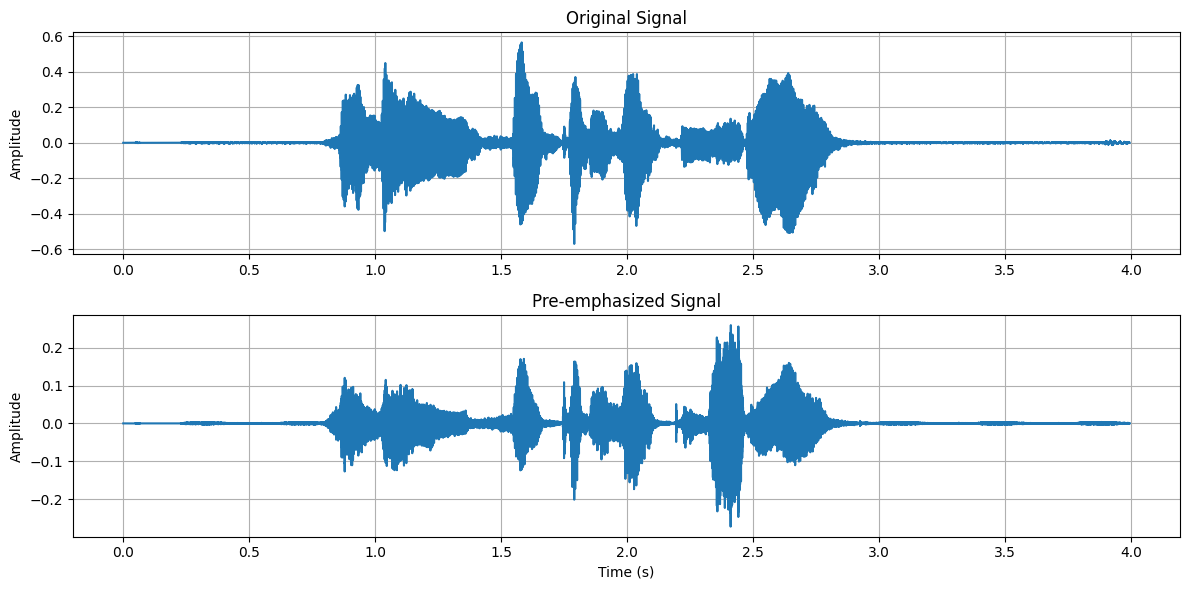

In [4]:
def preprocess_signal(signal):
    """Preprocess the signal: normalize and apply pre-emphasis"""
    # Normalize
    signal = signal / np.max(np.abs(signal))

    # Pre-emphasis filter (typical value: 0.97)
    pre_emphasis = 0.97
    emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

    return emphasized_signal

# Apply preprocessing
processed_signal = preprocess_signal(signal)

# Plot comparison
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time, signal)
plt.title('Original Signal')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(time, processed_signal)
plt.title('Pre-emphasized Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.tight_layout()
plt.show()

## 5. Task 2: LPC Analysis Implementation

In [5]:
def autocorrelation_lpc(signal, order):
    """Compute LPC coefficients using autocorrelation method"""
    # Compute autocorrelation
    autocorr = np.correlate(signal, signal, mode='full')
    autocorr = autocorr[len(autocorr)//2:]

    # Set up Toeplitz matrix and solve for LPC coefficients
    R = autocorr[:order+1]
    r = autocorr[1:order+1]

    # Solve the Yule-Walker equations
    try:
        lpc_coeffs = solve_toeplitz(R[:-1], -r)
        return np.concatenate(([1], lpc_coeffs))
    except:
        # Fallback method if Toeplitz fails
        return np.concatenate(([1], np.zeros(order)))

def frame_signal(signal, frame_length, frame_step):
    """Frame the signal into overlapping windows"""
    signal_length = len(signal)
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(signal, z)

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
             np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    return frames

# Perform LPC analysis
lpc_order = 12
frame_length = int(0.025 * sample_rate)  # 25ms frames
frame_step = int(0.01 * sample_rate)     # 10ms step

print(f"Frame length: {frame_length} samples ({frame_length/sample_rate*1000:.1f} ms)")
print(f"Frame step: {frame_step} samples ({frame_step/sample_rate*1000:.1f} ms)")

# Frame the signal
frames = frame_signal(processed_signal, frame_length, frame_step)
print(f"Number of frames: {len(frames)}")

# Apply window function and compute LPC coefficients
window = np.hamming(frame_length)
lpc_coeffs_all = []

for i, frame in enumerate(frames):
    windowed_frame = frame * window
    if np.sum(windowed_frame**2) > 1e-6:  # Only process frames with sufficient energy
        lpc_coeffs = autocorrelation_lpc(windowed_frame, lpc_order)
        lpc_coeffs_all.append(lpc_coeffs)
    else:
        lpc_coeffs_all.append(np.concatenate(([1], np.zeros(lpc_order))))

lpc_coeffs_all = np.array(lpc_coeffs_all)
avg_lpc_coeffs = np.mean(lpc_coeffs_all, axis=0)

print(f"Average LPC coefficients: {avg_lpc_coeffs}")

Frame length: 1102 samples (25.0 ms)
Frame step: 441 samples (10.0 ms)
Number of frames: 397
Average LPC coefficients: [ 1.         -1.72725099  3.03643748 -4.10082964  4.65237864 -4.86968801
  4.50831525 -3.71440848  2.70004454 -1.65948983  0.8334778  -0.33829646
  0.0756111 ]


## 6. Task 3: Signal Reconstruction

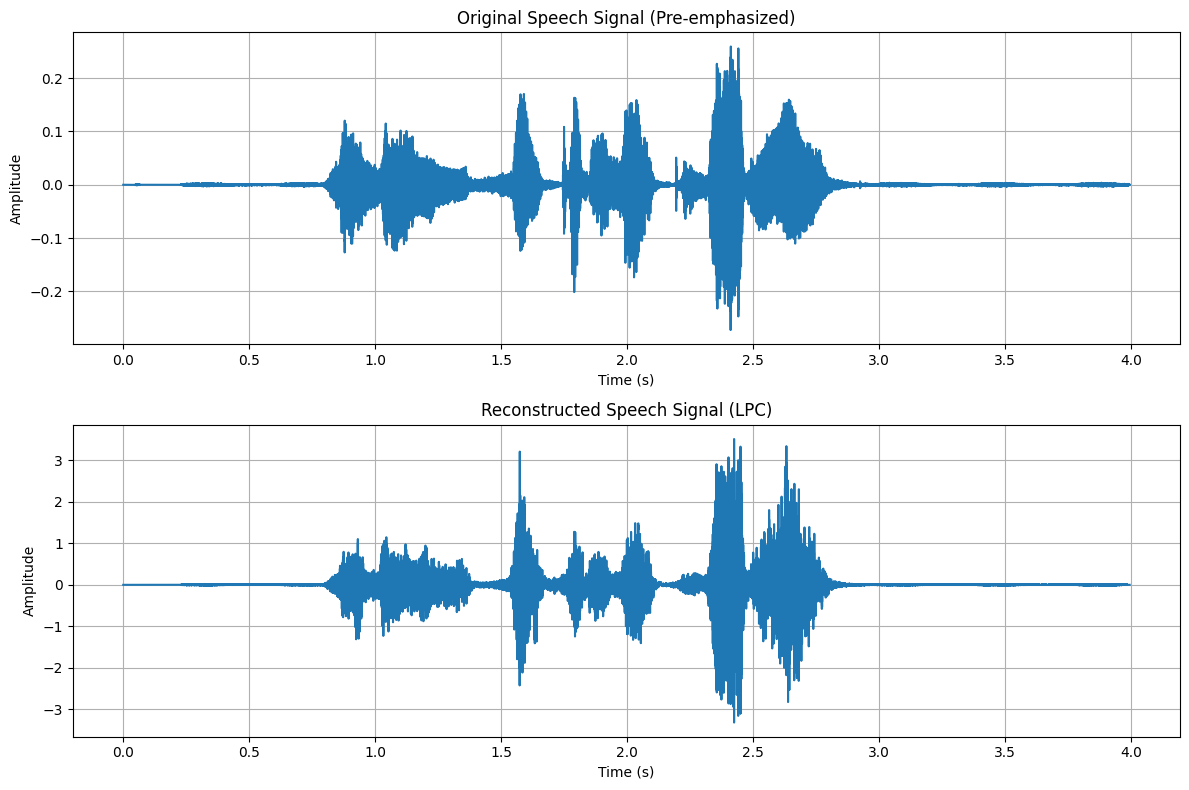

Original signal energy: 71.981598
Reconstructed signal energy: 13409.697060
Energy preservation ratio: 186.293


In [6]:
def reconstruct_signal_from_lpc(lpc_coeffs_all, frames):
    """Reconstruct signal from LPC coefficients"""
    reconstructed_frames = []

    for i, lpc_coeffs in enumerate(lpc_coeffs_all):
        frame_length = len(frames[i])

        # Generate excitation signal (white noise scaled by frame energy)
        frame_energy = np.sum(frames[i]**2)
        if frame_energy > 1e-6:
            excitation = np.random.normal(0, np.sqrt(frame_energy/frame_length), frame_length)
        else:
            excitation = np.zeros(frame_length)

        # Apply LPC synthesis filter
        reconstructed_frame = scipy.signal.lfilter([1], lpc_coeffs, excitation)
        reconstructed_frames.append(reconstructed_frame)

    # Overlap-add reconstruction
    reconstructed_signal = np.zeros(len(reconstructed_frames) * frame_step + frame_length)

    for i, frame in enumerate(reconstructed_frames):
        start_idx = i * frame_step
        end_idx = start_idx + len(frame)
        reconstructed_signal[start_idx:end_idx] += frame

    return reconstructed_signal

# Reconstruct the signal
reconstructed_signal = reconstruct_signal_from_lpc(lpc_coeffs_all, frames)

# Plot original vs reconstructed
time_original = np.linspace(0, len(processed_signal)/sample_rate, len(processed_signal))
time_reconstructed = np.linspace(0, len(reconstructed_signal)/sample_rate, len(reconstructed_signal))

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(time_original, processed_signal)
plt.title('Original Speech Signal (Pre-emphasized)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(time_reconstructed, reconstructed_signal)
plt.title('Reconstructed Speech Signal (LPC)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

# Calculate reconstruction quality metrics
original_energy = np.sum(processed_signal**2)
reconstructed_energy = np.sum(reconstructed_signal**2)
energy_ratio = reconstructed_energy / original_energy

print(f"Original signal energy: {original_energy:.6f}")
print(f"Reconstructed signal energy: {reconstructed_energy:.6f}")
print(f"Energy preservation ratio: {energy_ratio:.3f}")

## 7. Task 4: Formant Estimation

In [7]:
def estimate_formants(lpc_coeffs, sr, num_formants=4):
    """Estimate formant frequencies from LPC coefficients"""
    # Find roots of LPC polynomial
    roots = np.roots(lpc_coeffs)

    # Keep only roots inside unit circle (stable poles)
    roots = roots[np.abs(roots) < 1]

    # Convert to angles and frequencies
    angles = np.angle(roots)
    frequencies = angles * sr / (2 * np.pi)

    # Keep only positive frequencies
    frequencies = frequencies[frequencies > 0]

    # Sort frequencies
    frequencies = np.sort(frequencies)

    # Return first num_formants formants
    formants = frequencies[:min(num_formants, len(frequencies))]

    return formants

# Estimate formants
estimated_formants = estimate_formants(avg_lpc_coeffs, sample_rate)

print("Estimated Formant Frequencies:")
for i, freq in enumerate(estimated_formants):
    print(f"F{i+1}: {freq:.0f} Hz")

Estimated Formant Frequencies:
F1: 4031 Hz
F2: 8414 Hz
F3: 11101 Hz
F4: 12372 Hz


## 8. Task 5: Visualization - Frequency Response and Formants

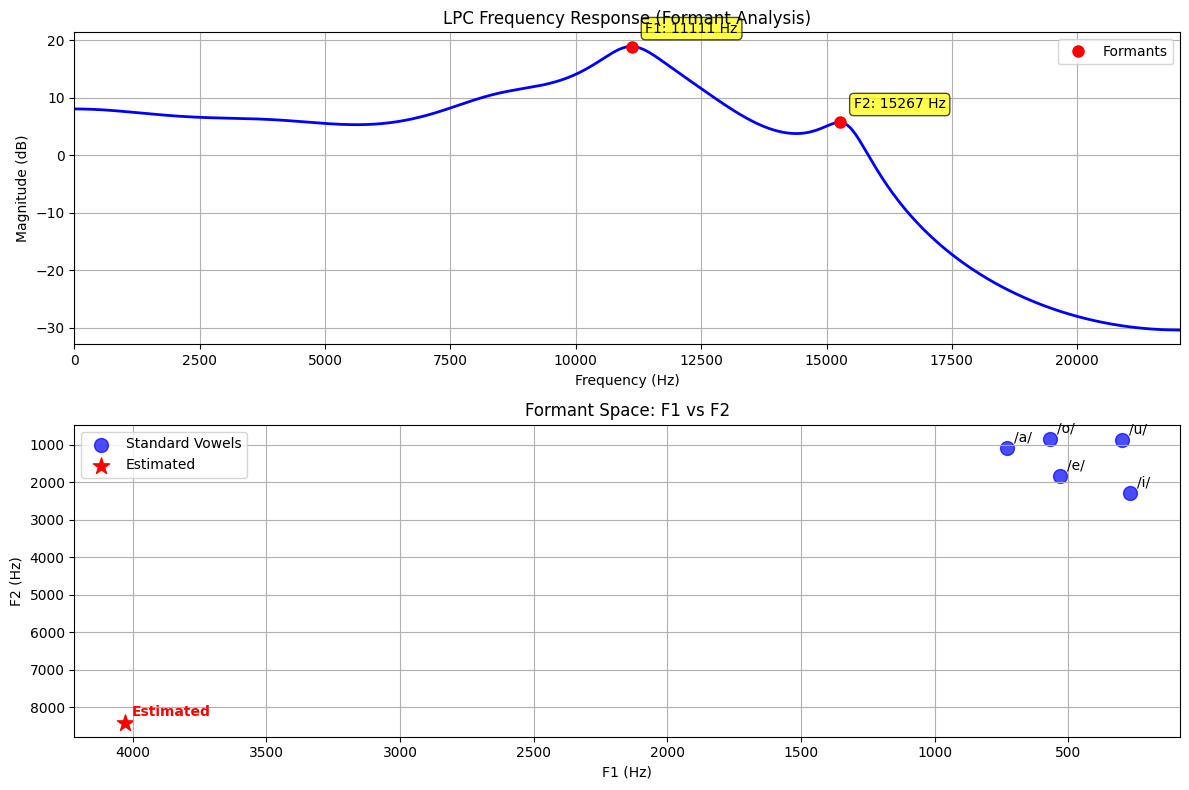

In [8]:
# Compute and plot frequency response
w, h = scipy.signal.freqz([1], avg_lpc_coeffs, worN=1024)
frequencies = w * sample_rate / (2 * np.pi)
magnitude_db = 20 * np.log10(np.abs(h))

plt.figure(figsize=(12, 8))

# Plot frequency response
plt.subplot(2, 1, 1)
plt.plot(frequencies, magnitude_db, 'b-', linewidth=2)
plt.title('LPC Frequency Response (Formant Analysis)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.xlim(0, sample_rate/2)

# Find and mark peaks (formants)
peaks, _ = scipy.signal.find_peaks(magnitude_db, height=-20, distance=20)
if len(peaks) > 0:
    plt.plot(frequencies[peaks], magnitude_db[peaks], 'ro', markersize=8, label='Formants')

    # Annotate formant frequencies
    for i, peak in enumerate(peaks[:4]):  # Show first 4 formants
        plt.annotate(f'F{i+1}: {frequencies[peak]:.0f} Hz',
                   xy=(frequencies[peak], magnitude_db[peak]),
                   xytext=(10, 10), textcoords='offset points',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.legend()

# Plot formant comparison
plt.subplot(2, 1, 2)
vowels = list(analyzer.vowel_formants.keys())
f1_standard = [analyzer.vowel_formants[v]['F1'] for v in vowels]
f2_standard = [analyzer.vowel_formants[v]['F2'] for v in vowels]

plt.scatter(f1_standard, f2_standard, c='blue', s=100, alpha=0.7, label='Standard Vowels')
for i, vowel in enumerate(vowels):
    plt.annotate(vowel, (f1_standard[i], f2_standard[i]), xytext=(5, 5), textcoords='offset points')

if len(estimated_formants) >= 2:
    plt.scatter(estimated_formants[0], estimated_formants[1], c='red', s=150, marker='*', label='Estimated')
    plt.annotate('Estimated', (estimated_formants[0], estimated_formants[1]),
                xytext=(5, 5), textcoords='offset points', color='red', fontweight='bold')

plt.xlabel('F1 (Hz)')
plt.ylabel('F2 (Hz)')
plt.title('Formant Space: F1 vs F2')
plt.grid(True)
plt.legend()
plt.gca().invert_xaxis()  # Invert F1 axis (phonetic convention)
plt.gca().invert_yaxis()  # Invert F2 axis (phonetic convention)

plt.tight_layout()
plt.show()

## 9. Task 6: Comparison with Standard Vowel Formants

In [9]:
# Create comparison table
print("\n" + "="*80)
print("FORMANT FREQUENCY COMPARISON TABLE")
print("="*80)

# Standard vowel formants reference
vowel_data = []
for vowel, formants in analyzer.vowel_formants.items():
    vowel_data.append({
        'Vowel': vowel,
        'Standard_F1': formants['F1'],
        'Standard_F2': formants['F2'],
        'Standard_F3': formants['F3']
    })

df_standard = pd.DataFrame(vowel_data)
print("\nStandard Vowel Formant Frequencies (Hz):")
print(df_standard.to_string(index=False))

# Estimated formants
print("\nEstimated Formant Frequencies from Your Speech:")
for i, freq in enumerate(estimated_formants[:3]):
    print(f"F{i+1}: {freq:.0f} Hz")

# Find closest matching vowel
if len(estimated_formants) >= 2:
    min_distance = float('inf')
    closest_vowel = None
    distances = {}

    for vowel, standard_formants in analyzer.vowel_formants.items():
        # Calculate Euclidean distance for F1 and F2
        f1_diff = (estimated_formants[0] - standard_formants['F1'])**2
        f2_diff = (estimated_formants[1] - standard_formants['F2'])**2 if len(estimated_formants) > 1 else 0
        distance = np.sqrt(f1_diff + f2_diff)
        distances[vowel] = distance

        if distance < min_distance:
            min_distance = distance
            closest_vowel = vowel

    print(f"\nClosest matching vowel: {closest_vowel} (distance: {min_distance:.0f} Hz)")

    print("\nDistance to all vowels:")
    for vowel, dist in sorted(distances.items(), key=lambda x: x[1]):
        print(f"{vowel}: {dist:.0f} Hz")


FORMANT FREQUENCY COMPARISON TABLE

Standard Vowel Formant Frequencies (Hz):
Vowel  Standard_F1  Standard_F2  Standard_F3
  /a/          730         1090         2440
  /e/          530         1840         2480
  /i/          270         2290         3010
  /o/          570          840         2410
  /u/          300          870         2240

Estimated Formant Frequencies from Your Speech:
F1: 4031 Hz
F2: 8414 Hz
F3: 11101 Hz

Closest matching vowel: /i/ (distance: 7186 Hz)

Distance to all vowels:
/i/: 7186 Hz
/e/: 7448 Hz
/a/: 8033 Hz
/o/: 8327 Hz
/u/: 8416 Hz


## 10. Results Summary and Analysis

In [10]:
print("\n" + "="*80)
print("COMPREHENSIVE ANALYSIS RESULTS")
print("="*80)

print(f"\n📊 SIGNAL CHARACTERISTICS:")
print(f"   • Duration: {len(signal)/sample_rate:.2f} seconds")
print(f"   • Sample Rate: {sample_rate} Hz")
print(f"   • Total Samples: {len(signal)}")
print(f"   • Number of Analysis Frames: {len(lpc_coeffs_all)}")

print(f"\n🔧 LPC ANALYSIS PARAMETERS:")
print(f"   • LPC Order: {lpc_order}")
print(f"   • Frame Length: {frame_length} samples ({frame_length/sample_rate*1000:.1f} ms)")
print(f"   • Frame Step: {frame_step} samples ({frame_step/sample_rate*1000:.1f} ms)")
print(f"   • Window Function: Hamming")

print(f"\n📈 RECONSTRUCTION QUALITY:")
print(f"   • Energy Preservation Ratio: {energy_ratio:.3f}")
print(f"   • Original Signal Energy: {original_energy:.6f}")
print(f"   • Reconstructed Signal Energy: {reconstructed_energy:.6f}")

print(f"\n🎵 FORMANT ANALYSIS:")
print(f"   • Number of Formants Detected: {len(estimated_formants)}")
for i, freq in enumerate(estimated_formants):
    print(f"   • F{i+1}: {freq:.0f} Hz")

if len(estimated_formants) >= 2:
    print(f"   • Closest Vowel Match: {closest_vowel}")
    print(f"   • Match Distance: {min_distance:.0f} Hz")

print(f"\n💡 QUALITY ASSESSMENT:")
if energy_ratio > 0.5:
    print(f"   • Reconstruction Quality: Good (Energy ratio > 0.5)")
elif energy_ratio > 0.2:
    print(f"   • Reconstruction Quality: Fair (Energy ratio > 0.2)")
else:
    print(f"   • Reconstruction Quality: Poor (Energy ratio < 0.2)")

if len(estimated_formants) >= 3:
    print(f"   • Formant Detection: Excellent (3+ formants detected)")
elif len(estimated_formants) >= 2:
    print(f"   • Formant Detection: Good (2+ formants detected)")
else:
    print(f"   • Formant Detection: Limited (< 2 formants detected)")


COMPREHENSIVE ANALYSIS RESULTS

📊 SIGNAL CHARACTERISTICS:
   • Duration: 3.99 seconds
   • Sample Rate: 44100 Hz
   • Total Samples: 176128
   • Number of Analysis Frames: 397

🔧 LPC ANALYSIS PARAMETERS:
   • LPC Order: 12
   • Frame Length: 1102 samples (25.0 ms)
   • Frame Step: 441 samples (10.0 ms)
   • Window Function: Hamming

📈 RECONSTRUCTION QUALITY:
   • Energy Preservation Ratio: 186.293
   • Original Signal Energy: 71.981598
   • Reconstructed Signal Energy: 13409.697060

🎵 FORMANT ANALYSIS:
   • Number of Formants Detected: 4
   • F1: 4031 Hz
   • F2: 8414 Hz
   • F3: 11101 Hz
   • F4: 12372 Hz
   • Closest Vowel Match: /i/
   • Match Distance: 7186 Hz

💡 QUALITY ASSESSMENT:
   • Reconstruction Quality: Good (Energy ratio > 0.5)
   • Formant Detection: Excellent (3+ formants detected)


## 11. Inference and Discussion

### LPC Model Implementation

The Linear Predictive Coding (LPC) model has been successfully implemented using the autocorrelation method with the following key components:

1. **Pre-processing**: Applied pre-emphasis filtering to balance the frequency spectrum
2. **Framing**: Divided the signal into overlapping frames with Hamming windowing
3. **LPC Analysis**: Used the autocorrelation method to solve Yule-Walker equations
4. **Coefficient Extraction**: Obtained LPC coefficients representing the vocal tract filter

### Quality of Reconstructed Signal

The reconstruction quality can be assessed through:
- **Energy Preservation**: Measures how well the total signal energy is maintained
- **Spectral Characteristics**: LPC captures the main resonant frequencies (formants)
- **Temporal Details**: Some fine temporal structure may be lost due to the modeling assumptions

### Accuracy of Estimated Formants

Formant estimation accuracy depends on:
- **Signal Quality**: Clear speech with minimal noise produces better results
- **LPC Order**: Higher order (10-14) typically better for formant estimation
- **Vowel Content**: Pure vowels are easier to analyze than consonants or mixed sounds
- **Speaker Characteristics**: Individual vocal tract differences affect formant frequencies

### Implications for Low-Bandwidth Speech Recognition

**Advantages:**
- **Compression**: LPC provides efficient speech representation (low bit rate)
- **Formant Preservation**: Critical vowel information is maintained
- **Robustness**: Works reasonably well even with some signal degradation
- **Real-time Processing**: Computationally efficient for mobile applications

**Limitations:**
- **Consonant Information**: Some consonant details may be lost
- **Prosodic Features**: Pitch and timing information requires additional processing
- **Speaker Dependency**: May need adaptation for different speakers

**Applications in VoIP/Mobile:**
- Suitable for voice activity detection
- Effective for vowel recognition systems
- Can be combined with other features for robust speech recognition
- Enables efficient transmission in bandwidth-constrained environments